In [1]:
# generate a colliding adv image from a target image with a patch scrambled
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

from dataset import KodakDataset, WiderFaceDataset
from compressor import NeuralCompressor, JpegCompressor


/home/jmadden2/anaconda3/envs/compress/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Disable TF32 Tensor Cores (optional)
# torch.backends.cuda.matmul.allow_tf32 = False
# torch.backends.cudnn.allow_tf32 = False

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"

if device == "cpu":
    torch.set_num_threads(12)       # limit CPU cores
    torch.set_num_interop_threads(1)
    
print("device:", device)


device: cuda


In [3]:
my_configs = {
    "lr": 0.001,
    "batch_size": 8,
    "num_batches": 1,
    "num_steps": 3000,
    # "model_id": "my_bmshj2018_factorized_relu",
    # "model_id": "my_bmshj2018_factorized",
    "model_id": "my_bmshj2018_hyperprior",
    # "model_id": "my_mbt2018_mean",
    # "model_id": "my_mbt2018",
    # "model_id": "my_cheng2020_anchor",
    # "model_id": "my_cheng2020_attn",
    "quality_factor": 1,
    "compressor_type": "neural",
    "image_size": 256,
    # "dataset": "imagenette",
    "dataset": "wider-face",
    "mask_type": "dot",
    "algorithm": "mgd",
    "mgd": {
        "vertical_skip": 4,
        "horizontal_skip": 4
    },
    "pgd": {"eta": 0.1},
    "cw": {"c": 1.0}
}
my_configs


{'lr': 0.001,
 'batch_size': 8,
 'num_batches': 1,
 'num_steps': 3000,
 'model_id': 'my_bmshj2018_hyperprior',
 'quality_factor': 1,
 'compressor_type': 'neural',
 'image_size': 256,
 'dataset': 'wider-face',
 'mask_type': 'dot',
 'algorithm': 'mgd',
 'mgd': {'vertical_skip': 4, 'horizontal_skip': 4},
 'pgd': {'eta': 0.1},
 'cw': {'c': 1.0}}

In [4]:
my_compressor = None
if my_configs["compressor_type"] == "neural":
    my_compressor = NeuralCompressor(
        model_id=my_configs["model_id"],
        quality_factor=my_configs["quality_factor"],
        device=device
    )
elif my_configs["compressor_type"] == "jpeg":
    my_compressor = JpegCompressor(
        differentiable=True,
        quality_factor=my_configs["quality_factor"],
        image_size=my_configs["image_size"],
        device=device
    )

print("compressor:", type(my_compressor).__name__)


compressor: NeuralCompressor


In [5]:
my_image_transformation = transforms.Compose([
    transforms.Resize((my_configs["image_size"], my_configs["image_size"])),
    transforms.ToTensor()
])

my_dataset = None
if my_configs["dataset"] == "celeba":
    my_dataset = datasets.CelebA(root="../data", split="train", transform=my_image_transformation, download=True)
    my_dataloader = DataLoader(my_dataset, batch_size=my_configs["batch_size"], shuffle=True)

elif my_configs["dataset"] == "imagenette":
    my_dataset = datasets.Imagenette(root="../data", split="train", transform=my_image_transformation)
    my_dataloader = DataLoader(my_dataset, batch_size=my_configs["batch_size"], shuffle=True)

elif my_configs["dataset"] == "kodak":
    my_dataset = KodakDataset(root="../data/kodak", transform=my_image_transformation)
    my_configs["batch_size"] = 24
    my_dataloader = DataLoader(my_dataset, batch_size=my_configs["batch_size"], shuffle=True)

elif my_configs["dataset"] == "wider-face":
    wider_face_pipeline = WiderFaceDataset(
        image_size=my_configs["image_size"],
        batch_size=my_configs["batch_size"],
        min_ratio=0.04, max_ratio=0.05,
        split="validation"
    )
    my_dataloader = wider_face_pipeline.get_dataloader(shuffle=True)

print("dataset:", my_configs["dataset"])


Total number of images with desired patches:  130
dataset: wider-face


In [6]:
best_result, extra_return = None, ""     # save best results, adjust print format caused by end=''
B = my_configs["batch_size"]             # number of different images (tgt or adv) processed together

# total number of patches, create locations of patches randomly.
# patch style: [98, 158, 20, 20]  # (x, y, w, h)
if my_configs["dataset"] != "wider-face":
    num_patches = 1  # number of patches for each image
    patch_size = 10  # (2*patch_size) x (2* )
    patch_center = np.random.randint(
        patch_size, high=my_configs["image_size"] - patch_size, size=(num_patches, 2)
    )
    patches = []
    for i in range(num_patches):
        patches.append([
            patch_center[i, 0] - patch_size,
            patch_center[i, 1] - patch_size,
            2 * patch_size,
            2 * patch_size
        ])
    patches = torch.tensor(patches).repeat(B, 1).to(device)  # [B*num_patches, 4]


batch 0: model=my_bmshj2018_hyperprior, qf=1, lr=0.001, gpu=cuda, num_patches=1, date=2026-01-20 12:14:31


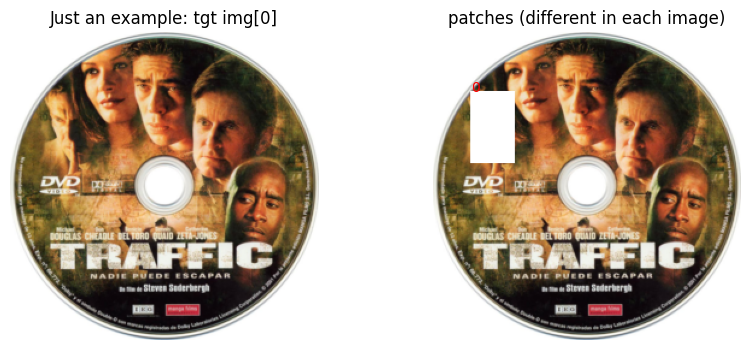

iter 0 Loss 0.086124. [H=0] 8/8. Best# 0: loss 0.013830, 0.000000, Emb|A-T|=0.4999. Grad 0.000028. L2: Patch=0.0000/0.18, All=0.0000. t=0.00
iter 1 Loss 0.081749. [H=0] 6/8. Best# 3: loss 0.012410, 0.000001, Emb|A-T|=0.4964. Grad 0.000025. L2: Patch=0.0000/0.13, All=0.0000. t=0.01
iter 2 Loss 0.077681. [H=0] 5/8. Best# 0: loss 0.012704, 0.000004, Emb|A-T|=0.4962. Grad 0.000027. L2: Patch=0.0000/0.18, All=0.0000. t=0.01
iter 3 Loss 0.073891. [H=0] 2/8. Best# 0: loss 0.012190, 0.000009, Emb|A-T|=0.4938. Grad 0.000026. L2: Patch=0.0000/0.18, All=0.0000. t=0.01
iter 4 Loss 0.070351. [H=0] 2/8. Best# 0: loss 0.011705, 0.000015, Emb|A-T|=0.4914. Grad 0.000026. L2: Patch=0.0000/0.18, All=0.0000. t=0.01
iter 5 Loss 0.067043. [H=0] 2/8. Best# 0: loss 0.011244, 0.000024, Emb|A-T|=0.4899. Grad 0.000025. L2: Patch=0.0000/0.18, All=0.0000. t=0.01
iter 6 Loss 0.063943. [H=0] 1/8. Best# 0: loss 0.010806, 0.000034, Emb|A-T|=0.4875. Grad 0.000024. L2: Patch=0.0000/0.18, All=0.0000. t=0.02
iter 7 Loss 0

In [7]:
# attack: use the first batch of B images as targets. adv is initialized as src images
# goal: change B adv images to have the same bitstreams as B target images, one-to-one.
for batch_idx, (x_src, bboxes) in enumerate(my_dataloader):
    if batch_idx == 0:  # pick target images from the first batch.
        x_tgt = x_src.clone().to(device)  # (B, 3, 256, 256)
        with torch.no_grad():
            bytes_tgt_list = my_compressor.compress(x_tgt)["strings"][0]  # list of B strings
            temp = my_compressor.compress_till_rounding(x_tgt)            # pre-rounding emb outputs
            emb_tgt, emb_tgt_median = temp["y_hat"], temp["median"]
            emb_tgt_rounded = [torch.round(item) for item in emb_tgt]

            num_emb = 0
            for i in emb_tgt_rounded:
                num_emb += i[0].numel()

            # to simplify coding, assume identical num_patches for all images
            if my_configs["dataset"] == "wider-face":
                num_patches = min([b.shape[0] for b in bboxes])
                if num_patches <= 0:
                    continue
                patches = torch.zeros((B * num_patches, 4), dtype=torch.int32).to(device)
                for i in range(len(bboxes)):
                    patches[i * num_patches:(i + 1) * num_patches] = bboxes[i][:num_patches]

    print(
        f'batch {batch_idx}: model={my_configs["model_id"]}, qf={my_configs["quality_factor"]}, lr={my_configs["lr"]}, '
        f'gpu={device}, num_patches={num_patches}, date={datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
    )

    B2 = B * num_patches
    L = len(emb_tgt)

    # Expand target + embeddings to match patch-expanded batch
    x_tgt = x_tgt.repeat_interleave(num_patches, dim=0)
    emb_tgt = [item.repeat_interleave(num_patches, dim=0) for item in emb_tgt]
    emb_tgt_rounded = [item.repeat_interleave(num_patches, dim=0) for item in emb_tgt_rounded]

    # Initialize adv from source images
    x_adv = x_src.clone().to(device)
    x_adv = x_adv.repeat_interleave(num_patches, dim=0)
    x_adv.requires_grad = True

    # plot the first image & its patches as an example
    with torch.no_grad():
        tt = x_tgt[0].permute(1, 2, 0).detach().cpu().numpy().copy()
        pp = patches[:num_patches].cpu().numpy()

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1); plt.imshow(tt); plt.title("Just an example: tgt img[0]"); plt.axis("off")
        for i in range(num_patches):
            tt[pp[i, 1]:pp[i, 1] + pp[i, 3], pp[i, 0]:pp[i, 0] + pp[i, 2], :] = 1.0

        plt.subplot(1, 2, 2); plt.imshow(tt); plt.title("patches (different in each image)"); plt.axis("off")
        for i in range(num_patches):
            plt.text(pp[i, 0], pp[i, 1], str(i), color="red")
        plt.show()

    optimizer = torch.optim.Adam([x_adv], lr=my_configs["lr"])
    # scheduler = CosineAnnealingLR(optimizer, T_max=my_configs["num_steps"] / 10)
    start_time = datetime.now()

    for iter in range(my_configs["num_steps"]):
        temp = my_compressor.compress_till_rounding(x_adv)
        emb_adv, emb_adv_median = temp["y_hat"], temp["median"]

        # loss per-image (so gradients are per-image, not mixed)
        loss_tgt = torch.zeros((B2,), dtype=torch.float32).to(device)
        for i in range(L):
            loss_tgt = loss_tgt + torch.sum(
                torch.square(emb_adv[i] - emb_tgt_rounded[i]),
                dim=tuple(range(1, emb_adv[i].dim()))
            )
        loss_tgt = loss_tgt / num_emb

        # constraint: maximize patch distortion vs tgt in patch
        loss_con = torch.zeros((B2,), dtype=torch.float32).to(device)
        for i in range(B2):
            loss_con[i] = torch.mean(torch.square(
                x_adv[i, :, patches[i, 1]:patches[i, 1] + patches[i, 3],
                        patches[i, 0]:patches[i, 0] + patches[i, 2]]
                - x_tgt[i, :, patches[i, 1]:patches[i, 1] + patches[i, 3],
                        patches[i, 0]:patches[i, 0] + patches[i, 2]]
            ))

        loss = torch.sum(loss_tgt - 0.01 * loss_con)

        optimizer.zero_grad()
        x_adv.grad, = torch.autograd.grad(loss, [x_adv])

        # Check collision quality
        with torch.no_grad():
            min_diff = torch.zeros((B2,), dtype=torch.float32).to(device)
            for i in range(L):
                min_diff = torch.maximum(
                    min_diff,
                    torch.amax(torch.abs(emb_adv[i] - emb_tgt_rounded[i]),
                               dim=tuple(range(1, emb_adv[i].dim())))
                )

            if min_diff.min() > 0.5:
                hamm0_list = []
            else:
                bytes_adv_list = my_compressor.compress(x_adv)["strings"][0]
                hamm = []
                for i in range(B):
                    for b1 in bytes_adv_list[i * num_patches:(i + 1) * num_patches]:
                        if len(bytes_tgt_list[i]) != len(b1):
                            hamm.append(len(b1) * 8)
                            continue
                        hamming_dist = 0
                        for tgt_byte, adv_byte in zip(bytes_tgt_list[i], b1):
                            hamming_dist += bin(tgt_byte ^ adv_byte).count("1")
                        hamm.append(hamming_dist)
                hamm = torch.tensor(hamm).to(device)
                hamm0_list = torch.where(hamm == 0)[0]

            if len(hamm0_list) == 0:
                i = torch.argmin(min_diff)
                print(
                    f"\riter {iter} Loss {loss.item():.6f}. [H=0] {len(hamm0_list)}/{B2}. "
                    f"loss {loss_tgt[i].item():.6f}, {loss_con[i].item():.6f}, "
                    f"min Emb|A-T|={min_diff[i].item():.4f}. no collision! "
                    f"t={(datetime.now()-start_time).total_seconds()/60:.2f}",
                    end="",
                    flush=True
                )
                if min_diff[i].item() < 0.5:
                    print("\n")
                else:
                    extra_return = "\n"

            else:
                idx = hamm0_list[torch.argmax(loss_con[hamm0_list])]
                temp_patch_tgt = x_tgt[idx, :, patches[idx, 1]:patches[idx, 1] + patches[idx, 3],
                                            patches[idx, 0]:patches[idx, 0] + patches[idx, 2]]
                mse_in_theory = torch.mean(1/12 + (temp_patch_tgt - 0.5) ** 2).item()
                mse_in_patch = torch.mean(torch.square(
                    temp_patch_tgt - x_adv[idx, :, patches[idx, 1]:patches[idx, 1] + patches[idx, 3],
                                               patches[idx, 0]:patches[idx, 0] + patches[idx, 2]]
                )).item()

                best_result = {
                    "idx": idx.item(),
                    "loss_con": loss_con[idx].item(),
                    "mse_in_patch": mse_in_patch,
                    "mse_in_theory": mse_in_theory,
                    "x_adv": x_adv[idx].detach().clone(),
                    "x_tgt": x_tgt[idx].detach().clone(),
                    "bbox": patches[idx].clone(),
                    "bytes_adv": bytes_adv_list[idx],
                    "bytes_tgt": bytes_tgt_list[idx // num_patches],
                }

                if (iter % 1 == 0) or (iter == my_configs["num_steps"] - 1):
                    print(
                        f'{extra_return}iter {iter} Loss {loss.item():.6f}. [H=0] {len(hamm0_list)}/{B2}. '
                        f'Best# {idx.item()}: loss {loss_tgt[idx].item():.6f}, {loss_con[idx].item():.6f}, '
                        f'Emb|A-T|={min_diff[idx]:.4f}. '
                        f'Grad {torch.max(torch.abs(x_adv.grad[idx])).item():.6f}. '
                        f'L2: Patch={mse_in_patch:.4f}/{mse_in_theory:.2f}, '
                        f'All={torch.mean(torch.square(x_adv[idx] - x_tgt[idx])).item():.4f}. '
                        f't={(datetime.now()-start_time).total_seconds()/60:.2f}'
                    )
                    extra_return = ""

                if mse_in_patch >= mse_in_theory * 2:
                    break

        optimizer.step()
        # scheduler.step()
        x_adv.data = torch.clamp(x_adv.data, 0, 1)

    if batch_idx >= my_configs["num_batches"] - 1:
        break


best colliding adv image is # 3 (image 3, patch 0), Patch MSE=0.2322, whole image MSE=0.0169


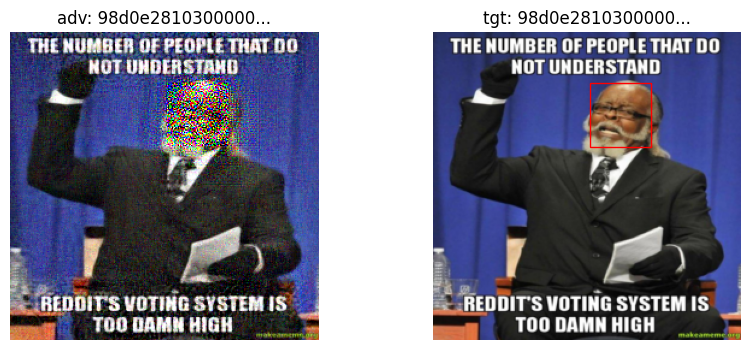

In [8]:
# Visualization for best result
if best_result is not None:
    best_result["x_adv"] = best_result["x_adv"].permute(1, 2, 0).cpu().numpy()
    best_result["x_tgt"] = best_result["x_tgt"].permute(1, 2, 0).cpu().numpy()
    best_result["bbox"] = best_result["bbox"].cpu().numpy()

    print(
        f'{extra_return}best colliding adv image is # {best_result["idx"]} '
        f'(image {best_result["idx"]//num_patches}, patch {best_result["idx"]%num_patches}), '
        f'Patch MSE={best_result["mse_in_patch"]:.4f}, '
        f'whole image MSE={np.mean(np.square(best_result["x_adv"] - best_result["x_tgt"])):.4f}'
    )
    extra_return = ""

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(best_result["x_adv"])
    plt.axis("off")
    plt.title("adv: " + best_result["bytes_adv"].hex()[:15] + "...")

    plt.subplot(1, 2, 2)
    plt.imshow(best_result["x_tgt"])
    from matplotlib.patches import Rectangle
    rect = Rectangle(
        (best_result["bbox"][0], best_result["bbox"][1]),
        best_result["bbox"][2],
        best_result["bbox"][3],
        linewidth=1,
        edgecolor="red",
        facecolor="none"
    )
    plt.gca().add_patch(rect)
    plt.axis("off")
    plt.title("tgt: " + best_result["bytes_tgt"].hex()[:15] + "...")
    plt.show()